In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
import sys
sys.path.append('/content/drive/My Drive/Risk Forecasting')

import numpy as np
import inspect
import pandas as pd
import matplotlib.dates as mdates
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import tensorflow as tf
from models import SVM, TFT_GRU, LGBM, Naive

plt.rc('font', family='serif')
plt.rc('text', usetex=False)
plt.rc('mathtext', fontset='stix')

# check GPU
device_name = tf.test.gpu_device_name()
if device_name:
    print(f'{device_name} found')
else:
    print("No GPU found")

feature_matrix = pd.read_pickle('/content/drive/My Drive/Risk Forecasting/features.pkl')
target_vector = (pd.read_excel('/content/drive/My Drive/Risk Forecasting/RESPONSE Main 1m.xls', skiprows=range(6))
                .rename(columns=lambda x: x.strip()).assign(**{'Effective date': lambda df: pd.to_datetime(df['Effective date'], errors='coerce')})
                .dropna(subset=['Effective date']).set_index('Effective date'))

feature_matrix.index = pd.to_datetime(feature_matrix.index, errors='coerce')
target_vector.index = pd.to_datetime(target_vector.index, errors='coerce')

# align indices
X = feature_matrix.loc[feature_matrix.index.intersection(target_vector.index)]
y = target_vector.loc[feature_matrix.index.intersection(target_vector.index)]

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

/device:GPU:0 found
X shape: (156, 15)
y shape: (156, 1)


In [19]:
def calculate_mape(actual, forecast):
    return np.mean(np.abs((actual - forecast) / actual)) * 100

def log_loss(actual, forecast):
    return np.mean((np.log(actual / forecast))**2)

def calculate_rmse(actual, forecast):
    return np.sqrt(np.mean((actual - forecast) ** 2))

In [20]:
def rolling_test(model_class, feature_matrix, feature_vector, chunk, predictions, sequence_length=None, model_name=""):
    '''rolling (sliding) test, that runs a model over t specified periods, models go through an independent walk-forward validation for each prediction.'''
    forecasts = np.array([])
    forecast_dates = []
    mae_scores = np.array([])
    mape_scores = np.array([])
    log_loss_scores = np.array([])
    rmse_scores = np.array([])

    t = 0

    while t < predictions:
        window = (chunk - predictions) + t

        X_fit = feature_matrix.iloc[t:window]
        y_fit = feature_vector.iloc[t:window]
        X_test = feature_matrix.iloc[window:window + 1]
        y_test = feature_vector.iloc[window:window + 1]

        if y_test.empty:
            print(f"no data for {window}")
            t += 1
            continue

        print(f"starting prerdiction for {y_test.index[0].strftime('%Y-%m-%d')}")
        print(f"training window shape: X_fit={X_fit.shape}, y_fit={y_fit.shape}")
        print(f"test window shape: X_test={X_test.shape}, y_test={y_test.shape}")

        try:
            model_args = inspect.signature(model_class.__init__).parameters
            model = model_class(sequence_length=sequence_length) if 'sequence_length' in model_args else model_class()
            model.fit(X_fit.values, y_fit.values)
            forecast = model.predict().flatten()

            forecasts = np.append(forecasts, forecast)
            forecast_dates.append(y_test.index[0])

            mae = mean_absolute_error(y_test.values.flatten(), forecast)
            mape = calculate_mape(y_test.values.flatten(), forecast)
            log_loss_value = log_loss(np.expand_dims(y_test.values.flatten(), axis=0), np.expand_dims(forecast, axis=0))
            rmse = calculate_rmse(y_test.values.flatten(), forecast)

            mae_scores = np.append(mae_scores, mae)
            mape_scores = np.append(mape_scores, mape)
            log_loss_scores = np.append(log_loss_scores, log_loss_value)
            rmse_scores = np.append(rmse_scores, rmse)

        except Exception as e:
            print(f"an error occurred: {e}")
            print(f"types - X_fit: {type(X_fit)}, y_fit: {type(y_fit)}")
            print(f"dims - X_fit: {X_fit.shape}, y_fit: {y_fit.shape}")

        t += 1

    avg_mae = np.mean(mae_scores)
    avg_mape = np.mean(mape_scores)
    avg_log_loss = np.mean(log_loss_scores)
    avg_rmse = np.mean(rmse_scores)

    print(f"avg. MAE: {avg_mae}")
    print(f"avg. MAPE: {avg_mape}")
    print(f"avg. Log Loss: {avg_log_loss}")
    print(f"avg. RMSE: {avg_rmse}")

    if forecast_dates:
        plt.figure(figsize=(12, 6))
        forecast_dates = pd.DatetimeIndex(forecast_dates)
        actuals = feature_vector.loc[forecast_dates]
        estimates = forecasts[:len(forecast_dates)]
        plt.plot(forecast_dates, actuals, 'o', color='grey', label='Actual')
        plt.plot(forecast_dates, estimates, 'x', color='black', label='Estimate')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title(f'Estimate vs Actual - {model_name}')
        plt.legend()
        plt.savefig(f'/content/drive/My Drive/Risk Forecasting/{model_name}_estimates_vs_actuals.png')
        plt.show()

        residuals = actuals.values.flatten() - estimates
        plt.figure(figsize=(12, 6))
        plt.plot(forecast_dates, residuals, 'x', color='black', label='Residuals')
        plt.axhline(y=0, color='grey', linestyle='--')
        plt.xlabel('Time')
        plt.ylabel('Residuals')
        plt.title(f'Residual Plot - {model_name}')
        plt.legend()
        plt.savefig(f'/content/drive/My Drive/Risk Forecasting/{model_name}_residual_plot.png')
        plt.show()
    else:
        print("forecasts were not made: unable to plot results.")

    return {'MAE': avg_mae, 'MAPE': avg_mape, 'Log Loss': avg_log_loss, 'RMSE': avg_rmse}


In [21]:
window = 50 # number of observations passed to model
predictions = 10 # subset at end of sliced observations dedicated to estimates (model will be fit on observations - predictions)
sequence_length = 5 # length of sequences (set to 5 for trading week)

In [22]:
model_metrics = {}

Streaming output truncated to the last 5000 lines.
[40]	valid_0's rmse: 0.0558919
[50]	valid_0's rmse: 0.0346933
[60]	valid_0's rmse: 0.0247689
[70]	valid_0's rmse: 0.0163023
[80]	valid_0's rmse: 0.00937933
[90]	valid_0's rmse: 0.0076254
[100]	valid_0's rmse: 0.00773952
[110]	valid_0's rmse: 0.00773952
Early stopping, best iteration is:
[94]	valid_0's rmse: 0.00740255
Training until validation scores don't improve for 20 rounds
[10]	valid_0's rmse: 0.178588
[20]	valid_0's rmse: 0.125999
[30]	valid_0's rmse: 0.0861043
[40]	valid_0's rmse: 0.0587501
[50]	valid_0's rmse: 0.039975
[60]	valid_0's rmse: 0.029596
[70]	valid_0's rmse: 0.0269145
[80]	valid_0's rmse: 0.0243196
[90]	valid_0's rmse: 0.0228443
[100]	valid_0's rmse: 0.0219747
[110]	valid_0's rmse: 0.0219747
Early stopping, best iteration is:
[95]	valid_0's rmse: 0.0219747
Training until validation scores don't improve for 20 rounds
[10]	valid_0's rmse: 0.218494
[20]	valid_0's rmse: 0.152705
[30]	valid_0's rmse: 0.105112
[40]	valid_0

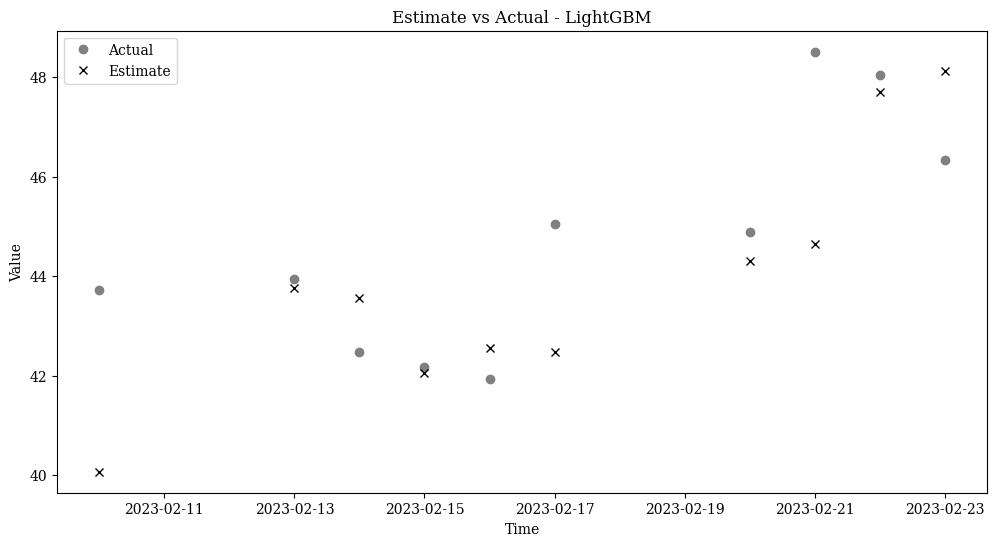

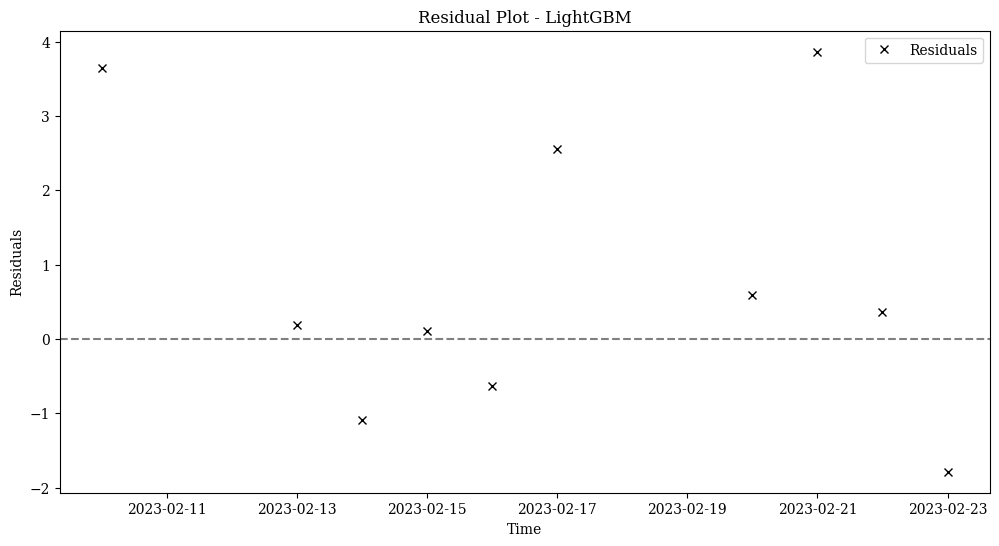

In [23]:
model_metrics['LightGBM'] = rolling_test(LGBM, X, y, chunk=(window + predictions), predictions=predictions, sequence_length=sequence_length, model_name='LightGBM')

starting prerdiction for 2023-02-10
training window shape: X_fit=(50, 15), y_fit=(50, 1)
test window shape: X_test=(1, 15), y_test=(1, 1)
X dims pre-sequiencing: (50, 15)
y dims pre-sequencing: (50, 1)
stacked shape: (50, 16)
Best params found: {'kernel': 'sigmoid', 'C': 20, 'epsilon': 0.05, 'gamma': 0.05} with score 2347.602795787043
Model is properly fitted and ready for prediction.
starting prerdiction for 2023-02-13
training window shape: X_fit=(50, 15), y_fit=(50, 1)
test window shape: X_test=(1, 15), y_test=(1, 1)
X dims pre-sequiencing: (50, 15)
y dims pre-sequencing: (50, 1)
stacked shape: (50, 16)
Best params found: {'kernel': 'sigmoid', 'C': 20, 'epsilon': 0.05, 'gamma': 0.05} with score 2320.0754453113996
Model is properly fitted and ready for prediction.
starting prerdiction for 2023-02-14
training window shape: X_fit=(50, 15), y_fit=(50, 1)
test window shape: X_test=(1, 15), y_test=(1, 1)
X dims pre-sequiencing: (50, 15)
y dims pre-sequencing: (50, 1)
stacked shape: (50, 1

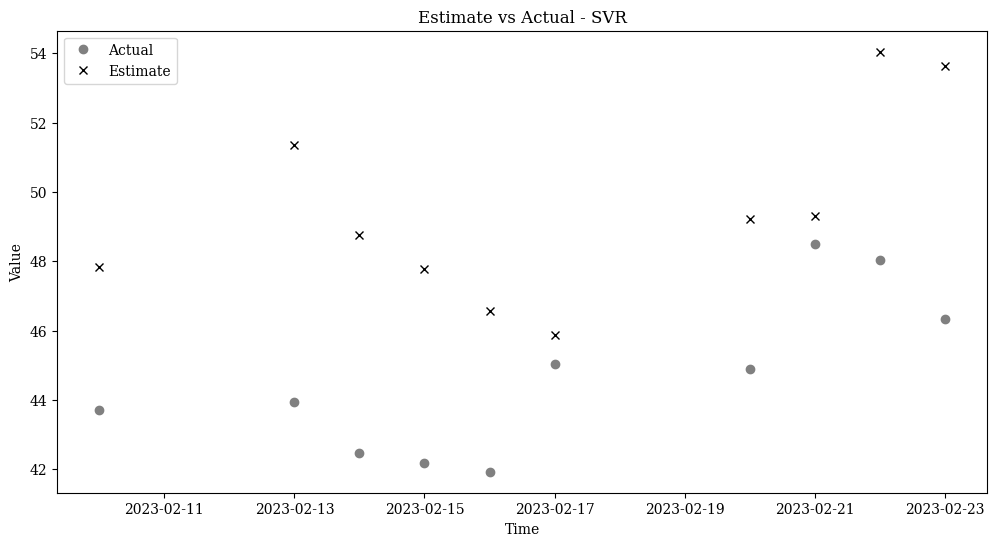

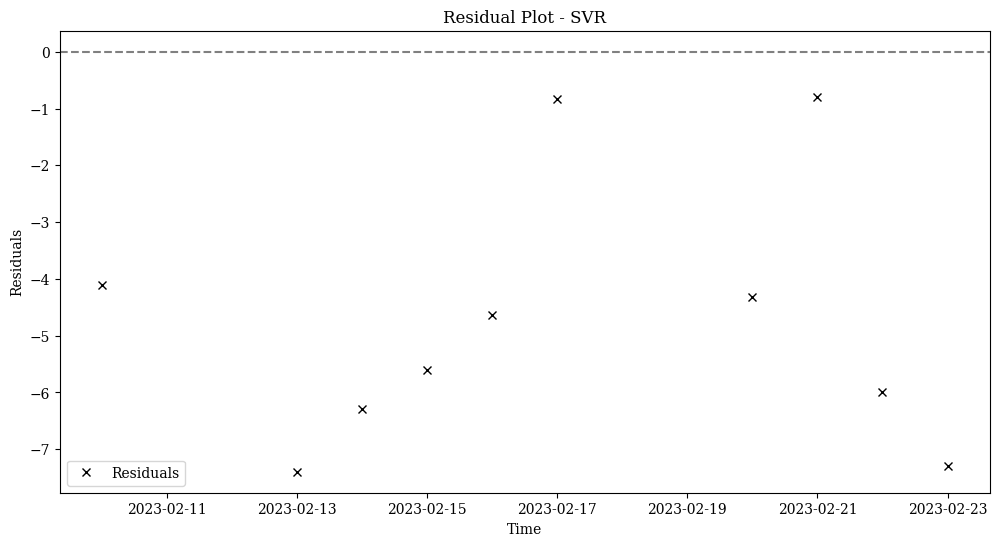

In [24]:
model_metrics['SVR'] = rolling_test(SVM, X, y, chunk=(window + predictions), predictions=predictions, sequence_length=sequence_length, model_name='SVR')

starting prerdiction for 2023-02-10
training window shape: X_fit=(50, 15), y_fit=(50, 1)
test window shape: X_test=(1, 15), y_test=(1, 1)
starting prerdiction for 2023-02-13
training window shape: X_fit=(50, 15), y_fit=(50, 1)
test window shape: X_test=(1, 15), y_test=(1, 1)
starting prerdiction for 2023-02-14
training window shape: X_fit=(50, 15), y_fit=(50, 1)
test window shape: X_test=(1, 15), y_test=(1, 1)
starting prerdiction for 2023-02-15
training window shape: X_fit=(50, 15), y_fit=(50, 1)
test window shape: X_test=(1, 15), y_test=(1, 1)
starting prerdiction for 2023-02-16
training window shape: X_fit=(50, 15), y_fit=(50, 1)
test window shape: X_test=(1, 15), y_test=(1, 1)
starting prerdiction for 2023-02-17
training window shape: X_fit=(50, 15), y_fit=(50, 1)
test window shape: X_test=(1, 15), y_test=(1, 1)
starting prerdiction for 2023-02-20
training window shape: X_fit=(50, 15), y_fit=(50, 1)
test window shape: X_test=(1, 15), y_test=(1, 1)
starting prerdiction for 2023-02-2

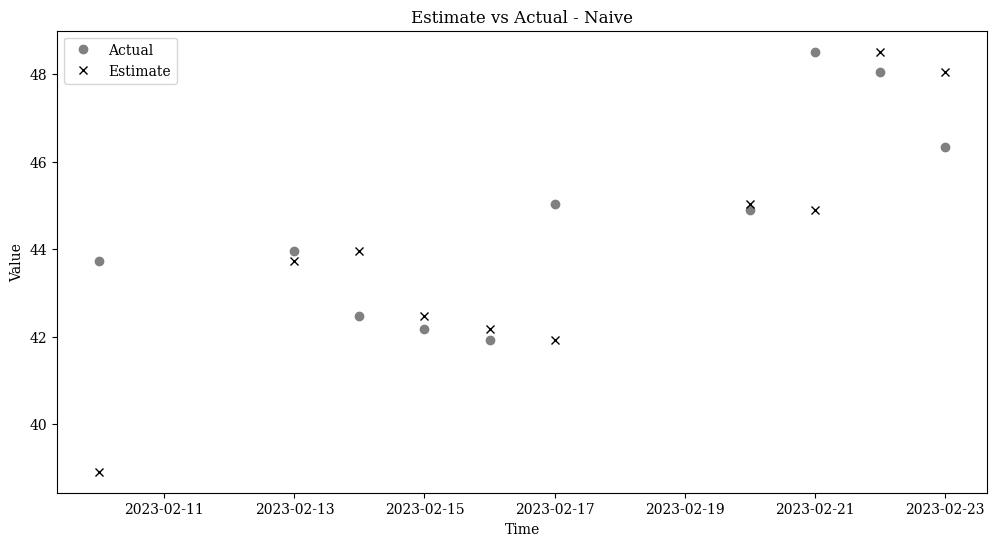

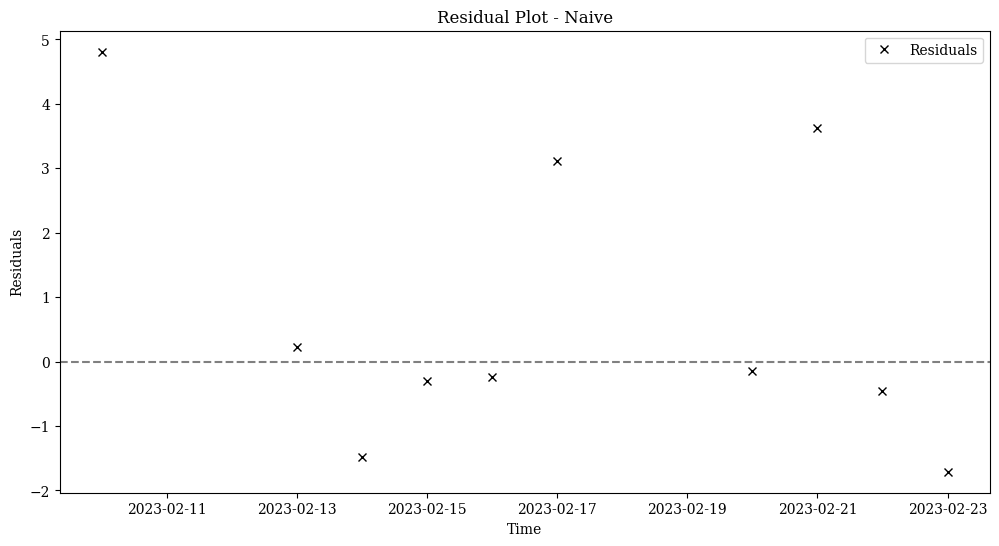

In [25]:
model_metrics['Naive Forecast'] = rolling_test(Naive, X, y, chunk=(window + predictions), predictions=predictions, model_name='Naive')

In [26]:
# with tf.device('/device:GPU:0'):
#     rolling_test(TFT_GRU, X, y, chunk=(window + predictions), predictions=predictions, sequence_length=sequences)

In [27]:
metrics_df = pd.DataFrame(model_metrics)

metrics_df

,LightGBM,SVR,Naive Forecast
MAE,1.481801,4.727362,1.611000
MAPE,3.265206,10.671554,3.564271
Log Loss,0.002045,0.012211,0.002742
RMSE,1.481801,4.727362,1.611000


In [28]:
latex_code = metrics_df.to_latex(index=False)
with open('/content/drive/My Drive/Risk Forecasting/model_metrics_table.tex', 'w') as f:
    f.write(latex_code)